In [ ]:
'''
Train data 2100 ,Test data 900 & Val  data 1000
epochs 5
Used EfficientNet series models
Ensemble Accuracy 56.3%
'''

In [ ]:
#content google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
import glob
#select tensorflow's version
%tensorflow_version 2.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 16.8 MB/s 
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# HDF5フォーマットでモデルを保存するために必要
!pip install -q pyyaml h5py  

In [ ]:
image_generator=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
    )

In [ ]:
#各データセットのディレクトリを選択し、全画像をリサイズする。
#ディレクトリへのバスを受け取り、拡張・正規化したデータバッチを生成する。
batch_size=32

train_generator = image_generator.flow_from_directory(
    '/content/drive/MyDrive/data/train',
    target_size=(224, 224),
    #class_mode='binary',
    batch_size=batch_size,
    subset='training',
)

val_generator = image_generator.flow_from_directory(
    '/content/drive/MyDrive/data/train',
    target_size=(224, 224),
    #class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

Found 8471 images belonging to 4 classes.
Found 3630 images belonging to 4 classes.


In [ ]:
# train 画像データ
train_generator.image_shape

(224, 224, 3)

In [ ]:
# train ラベル
train_generator.class_indices

{'CNV_train': 0, 'DME_train': 1, 'DRUSEN_train': 2, 'NORMAL_train': 3}

In [ ]:
# train 全てのラベル
train_generator.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


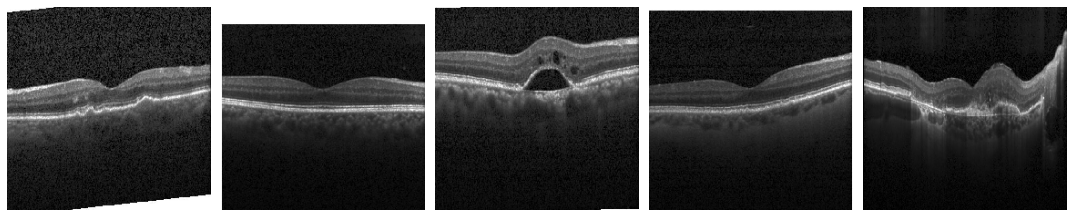

In [ ]:
training_images, training_labels = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print(training_labels)
plotImages(training_images[:5])

In [ ]:
#使用するモデルの選択（特徴抽出器/分類器）_ efficientnetv2
feature_extractor_url="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"

#入力画像サイズを決定する(モデルに適したサイズを設定)
feature_extractor_layer=hub.KerasLayer(feature_extractor_url,input_shape=(512,512,3))

#学習済み重みを固定する
feature_extractor_layer.trainable=False

#上位の分類層を接合する
ebc1=Sequential([feature_extractor_layer,layers.Dense(train_generator.num_classes,activation='softmax')])
#sigmoid SparseCategoricalCrossentropy

#モデルの概要を確認する
ebc1.summary()

ebc1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#モデル設定
MODEL_DIR='/content/drive/MyDrive/result6'
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)

checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR,"model-{epoch:02d}.h5"),
                                              monitor='val_loss',
                                              mode='min',
                                              save_weights_only=True,
                                              verbose=1
                                              )
#filepath:モデルファイルを保存する場所を選択
#monitor:監視するメトリック名
#mode:ファイルを上書きするかどうか
#save_weights_only:モデルのウェイトのみを保存する
#verbose:1、冗長モード    

In [ ]:
checkpoint1=tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR,"model1-{epoch:02d}.h5"),
                                              monitor='val_loss',
                                              mode='min',
                                              save_weights_only=True,
                                              verbose=1
                                              )

In [ ]:
checkpoint2=tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR,"model2-{epoch:02d}.h5"),
                                              monitor='val_loss',
                                              mode='min',
                                              save_weights_only=True,
                                              verbose=1
                                              )

In [ ]:
checkpoint3=tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR,"model3-{epoch:02d}.h5"),
                                              monitor='val_loss',
                                              mode='min',
                                              save_weights_only=True,
                                              verbose=1
                                              )

In [ ]:
#訓練プロセスの可視化
#カスタムコールバックを作成して、すべてのエポックでのトレーニングの進行状況を視覚化します
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses=[]
    self.batch_acc=[]
    
  def on_train_batch_end(self,batch,logs=1e-12):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

In [ ]:
#形状設定
test_data=image_generator.flow_from_directory('/content/drive/MyDrive/data/test',target_size=(224,224))
val_data=image_generator.flow_from_directory('/content/drive/MyDrive/data/val',target_size=(224,224))
gizi_data=image_generator.flow_from_directory('/content/drive/MyDrive/data/train',target_size=(224,224))

Found 4010 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 12101 images belonging to 4 classes.


In [ ]:
#各データセットの画像バッチ形状と、ラベルのバッチ形状を表示する
for image_test_batch,label_test_batch in test_data:
  print("Image batch shape:",image_test_batch.shape)
  print("Label batch shape:",label_test_batch.shape)
  break

for image_test_batch,label_test_batch in train_generator:
  print("Image batch shape:",image_test_batch.shape)
  print("Label batch shape:",label_test_batch.shape)
  break

for image_test_batch,label_test_batch in val_generator:
  print("Image batch shape:",image_test_batch.shape)
  print("Label batch shape:",label_test_batch.shape)
  break

for image_test_batch,label_test_batch in gizi_data:
  print("Image batch shape:",image_test_batch.shape)
  print("Label batch shape:",label_test_batch.shape)
  break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


In [ ]:
batch_stats_callback=CollectBatchStats()
batch_size=32
epochz=3
epoch=5
#steps_per_epoch
s_p_e=np.ceil(train_generator.samples/batch_size)

NameError: ignored

model1

In [ ]:
ebc1.fit(         train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=val_generator,
                  callbacks=[checkpoint1,batch_stats_callback],
                  )

Epoch 1/3
265/265 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.7607
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 3116s 12s/step - loss: 0.6450 - accuracy: 0.7607 - val_loss: 0.6152 - val_accuracy: 0.7592
Epoch 2/3
265/265 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8906
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 229s 863ms/step - loss: 0.3243 - accuracy: 0.8906 - val_loss: 0.4692 - val_accuracy: 0.8187
Epoch 3/3
265/265 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.9043
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 224s 846ms/step - loss: 0.2818 - accuracy: 0.9043 - val_loss: 0.5375 - val_accuracy: 0.7970


In [ ]:
#上位分類層を接合
ebc1=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax')])

ebc1.summary()

ebc1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#擬似ラベル作成
history=ebc1.fit(train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=gizi_data,
                  callbacks=[checkpoint1,batch_stats_callback]
                  )



Epoch 1/3
265/265 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.9062
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 416s 2s/step - loss: 0.3191 - accuracy: 0.9062 - val_loss: 0.3673 - val_accuracy: 0.8646
Epoch 2/3
265/265 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.8125
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 410s 2s/step - loss: 0.6324 - accuracy: 0.8125 - val_loss: 0.3014 - val_accuracy: 0.8950
Epoch 3/3
265/265 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.9062
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 409s 2s/step - loss: 0.2661 - accuracy: 0.9062 - val_loss: 0.3263 - val_accuracy: 0.8827


In [ ]:
#疑似ラベルの予測
gizi_label1=ebc1.predict(gizi_data)

379/379 [==============================] - 214s 555ms/step


In [ ]:
feature_extractor_layer.trainable=False
#入力画像ノイズ(rand augmentation)の設定
data_augmentation=Sequential([layers.RandomRotation(2.10)])
#モデルノイズ（stochastic depth）の設定
stochastic_Depth=Sequential([tfa.layers.StochasticDepth(0.35)])

#モデルにrand augmentationを適用
model1=Sequential([data_augmentation])
#モデルにstochastic depthを適用
model1=Sequential([stochastic_Depth])

#モデルノイズ（dropout）の設定と適用
model1=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax'),
                           #layers.Dropout(0.3)sigmoid softmax
                  ])

In [ ]:
#model1
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#model1
history=model1.fit(gizi_data,
                  epochs=epochz,
                  steps_per_epoch=np.ceil(gizi_data.samples/batch_size),
                  validation_data=val_generator,
                  #callbacks=[checkpoint1,batch_stats_callback]
                  )

Epoch 1/3
379/379 [==============================] - 291s 742ms/step - loss: 0.5422 - accuracy: 0.7958 - val_loss: 0.3974 - val_accuracy: 0.8609
Epoch 2/3
379/379 [==============================] - 277s 730ms/step - loss: 0.3287 - accuracy: 0.8820 - val_loss: 0.3340 - val_accuracy: 0.8774
Epoch 3/3
379/379 [==============================] - 277s 732ms/step - loss: 0.2852 - accuracy: 0.8984 - val_loss: 0.3080 - val_accuracy: 0.8843


In [ ]:
#上位分類層を接合
model1=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax')])

model1.summary()

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
history=model1.fit(train_generator,
                  epochs=epoch,
                  steps_per_epoch=s_p_e,
                  validation_data=val_generator,
                  callbacks=[checkpoint1,batch_stats_callback]
                  )

#y_prob = model1.predict(val_data)
#y_pred1 = y_prob.argmax(axis=-1)
#y_test1=np.argmax(y_test, axis=1)
# accuracy
#print(model1+" accuracy: ",accuracy_score(y_test1,y_pred1))
#del model1 , y_pred1, y_test1

Epoch 1/5
265/265 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.8125
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 281s 1s/step - loss: 0.6966 - accuracy: 0.8125 - val_loss: 0.5360 - val_accuracy: 0.8030
Epoch 2/5
265/265 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9375
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 252s 951ms/step - loss: 0.2126 - accuracy: 0.9375 - val_loss: 0.4963 - val_accuracy: 0.8129
Epoch 3/5
265/265 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9688
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 254s 959ms/step - loss: 0.1398 - accuracy: 0.9688 - val_loss: 0.4747 - val_accuracy: 0.8256
Epoch 4/5
265/265 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9375
Epoch 4: savin

In [ ]:
model1.save('/content/drive/MyDrive/result6/model1.h5/')

model2

In [ ]:
#使用するモデルの選択（特徴抽出器/分類器）_ efficientnetb1
feature_extractor_url_b1="https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

#入力画像サイズを決定する(モデルに適したサイズを設定)
feature_extractor_layer_b1=hub.KerasLayer(feature_extractor_url_b1,input_shape=(512,512,3))

#学習済み重みを固定する
feature_extractor_layer_b1.trainable=False

#上位の分類層を接合する
ebc2=Sequential([feature_extractor_layer_b1,layers.Dense(train_generator.num_classes,activation='softmax')])

#モデルの概要を確認する
ebc2.summary()

ebc2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              6575232   
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 6,580,356
Trainable params: 5,124
Non-trainable params: 6,575,232
_________________________________________________________________


In [ ]:
ebc2.fit(         train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=test_data,
                  callbacks=[checkpoint2,batch_stats_callback],
                  )

Epoch 1/3
265/265 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7566
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 1417s 5s/step - loss: 0.6977 - accuracy: 0.7566 - val_loss: 0.6693 - val_accuracy: 0.7616
Epoch 2/3
265/265 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8626
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 101s 382ms/step - loss: 0.4249 - accuracy: 0.8626 - val_loss: 0.6176 - val_accuracy: 0.7756
Epoch 3/3
265/265 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8864
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 99s 375ms/step - loss: 0.3542 - accuracy: 0.8864 - val_loss: 0.5953 - val_accuracy: 0.7873


In [ ]:
#上位分類層を接合
ebc2=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax')])

ebc2.summary()

ebc2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_5 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#擬似ラベル作成
history=ebc2.fit(train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=gizi_data,
                  #callbacks=[checkpoint2,batch_stats_callback]
                  )



Epoch 1/3
265/265 [==============================] - 371s 1s/step - loss: 0.5410 - accuracy: 0.7936 - val_loss: 0.3896 - val_accuracy: 0.8550
Epoch 2/3
265/265 [==============================] - 360s 1s/step - loss: 0.3146 - accuracy: 0.8909 - val_loss: 0.3211 - val_accuracy: 0.8868
Epoch 3/3
265/265 [==============================] - 360s 1s/step - loss: 0.2674 - accuracy: 0.9030 - val_loss: 0.3031 - val_accuracy: 0.8903


In [ ]:
gizi_label2=ebc2.predict(gizi_data)

379/379 [==============================] - 214s 554ms/step


In [ ]:
feature_extractor_layer.trainable=False
#入力画像ノイズ(rand augmentation)の設定
data_augmentation=Sequential([layers.RandomRotation(2.10)])
#モデルノイズ（stochastic depth）の設定
stochastic_Depth=Sequential([tfa.layers.StochasticDepth(0.35)])

#モデルにrand augmentationを適用
model2=Sequential([data_augmentation])
#モデルにstochastic depthを適用
model2=Sequential([stochastic_Depth])

model2=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax'),
                           #layers.Dropout(0.3)
                  ])

In [ ]:
#model2
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_6 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#model2
history=model2.fit(gizi_data,
                  epochs=epochz,
                  steps_per_epoch=np.ceil(gizi_data.samples/batch_size),
                  validation_data=val_generator,
                  #callbacks=[checkpoint2,batch_stats_callback]
                  )


Epoch 1/3
379/379 [==============================] - 292s 742ms/step - loss: 0.5172 - accuracy: 0.8075 - val_loss: 0.3882 - val_accuracy: 0.8612
Epoch 2/3
379/379 [==============================] - 276s 728ms/step - loss: 0.3377 - accuracy: 0.8818 - val_loss: 0.3241 - val_accuracy: 0.8865
Epoch 3/3
379/379 [==============================] - 276s 729ms/step - loss: 0.2869 - accuracy: 0.8991 - val_loss: 0.2896 - val_accuracy: 0.8983


In [ ]:
history=model2.fit(train_generator,
                  epochs=epoch,
                  steps_per_epoch=s_p_e,
                  validation_data=val_generator,
                  callbacks=[checkpoint2,batch_stats_callback]
                  )

Epoch 1/5
265/265 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9375
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 221s 833ms/step - loss: 0.1609 - accuracy: 0.9375 - val_loss: 0.3362 - val_accuracy: 0.8711
Epoch 2/5
265/265 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9062
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 220s 832ms/step - loss: 0.2078 - accuracy: 0.9062 - val_loss: 0.3563 - val_accuracy: 0.8634
Epoch 3/5
265/265 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 1.0000
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 220s 829ms/step - loss: 0.1053 - accuracy: 1.0000 - val_loss: 0.3518 - val_accuracy: 0.8658
Epoch 4/5
265/265 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9375
Epoch 4: sa

In [ ]:
model2.save('/content/drive/MyDrive/result6/model2.h5/')

model3

In [ ]:
#使用するモデルの選択（特徴抽出器/分類器）_ efficientnetb2
feature_extractor_url_b2="https://tfhub.dev/google/efficientnet/b2/feature-vector/1"

#入力画像サイズを決定する(モデルに適したサイズを設定)
feature_extractor_layer_b2=hub.KerasLayer(feature_extractor_url_b2,input_shape=(512,512,3))

#学習済み重みを固定する
feature_extractor_layer_b2.trainable=False

#上位の分類層を接合する
ebc3=Sequential([feature_extractor_layer_b2,layers.Dense(train_generator.num_classes,activation='softmax')])

#モデルの概要を確認する
ebc3.summary()

ebc3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1408)              7768562   
                                                                 
 dense_7 (Dense)             (None, 4)                 5636      
                                                                 
Total params: 7,774,198
Trainable params: 5,636
Non-trainable params: 7,768,562
_________________________________________________________________


In [ ]:
ebc3.fit(         train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=val_generator,
                  callbacks=[checkpoint3,batch_stats_callback],
                  )

Epoch 1/3
265/265 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7588
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 152s 553ms/step - loss: 0.6645 - accuracy: 0.7588 - val_loss: 0.6259 - val_accuracy: 0.7675
Epoch 2/3
265/265 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8631
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 116s 439ms/step - loss: 0.4219 - accuracy: 0.8631 - val_loss: 0.5657 - val_accuracy: 0.7769
Epoch 3/3
265/265 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8842
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 104s 395ms/step - loss: 0.3580 - accuracy: 0.8842 - val_loss: 0.5517 - val_accuracy: 0.7840


In [ ]:
#上位分類層を接合
ebc3=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax')])

ebc3.summary()

ebc3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_8 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#擬似ラベル作成
history=ebc3.fit(train_generator,
                  epochs=epochz,
                  steps_per_epoch=s_p_e,
                  validation_data=gizi_data,
                  #callbacks=[checkpoint3,batch_stats_callback]
                  )



Epoch 1/3
265/265 [==============================] - 373s 1s/step - loss: 0.5849 - accuracy: 0.7856 - val_loss: 0.3929 - val_accuracy: 0.8641
Epoch 2/3
265/265 [==============================] - 360s 1s/step - loss: 0.3197 - accuracy: 0.8896 - val_loss: 0.3418 - val_accuracy: 0.8779
Epoch 3/3
265/265 [==============================] - 360s 1s/step - loss: 0.2666 - accuracy: 0.9087 - val_loss: 0.3055 - val_accuracy: 0.8932


In [ ]:
gizi_label3=ebc3.predict(gizi_data)

379/379 [==============================] - 213s 553ms/step


In [ ]:
feature_extractor_layer.trainable=False
#入力画像ノイズ(rand augmentation)の設定
data_augmentation=Sequential([layers.RandomRotation(2.10)])
#モデルノイズ（stochastic depth）の設定
stochastic_Depth=Sequential([tfa.layers.StochasticDepth(0.35)])

#モデルにrand augmentationを適用
model3=Sequential([data_augmentation])
#モデルにstochastic depthを適用
model3=Sequential([stochastic_Depth])

model3=Sequential([feature_extractor_layer,
                           layers.Dense(train_generator.num_classes,activation='softmax'),
                           #layers.Dropout(0.3)
                  ])

In [ ]:
#model3
model3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense_9 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 207,620,956
Trainable params: 5,124
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
#model3
history=model3.fit(gizi_data,
                  epochs=epochz,
                  steps_per_epoch=np.ceil(gizi_data.samples/batch_size),
                  validation_data=val_generator,
                  #callbacks=[checkpoint3,batch_stats_callback]
                  )

Epoch 1/3
379/379 [==============================] - 291s 746ms/step - loss: 0.5356 - accuracy: 0.7989 - val_loss: 0.3965 - val_accuracy: 0.8556
Epoch 2/3
379/379 [==============================] - 276s 728ms/step - loss: 0.3365 - accuracy: 0.8807 - val_loss: 0.3066 - val_accuracy: 0.8898
Epoch 3/3
379/379 [==============================] - 276s 728ms/step - loss: 0.2875 - accuracy: 0.8957 - val_loss: 0.3297 - val_accuracy: 0.8730


In [ ]:
history=model3.fit(train_generator,
                  epochs=epoch,
                  steps_per_epoch=s_p_e,
                  validation_data=val_generator,
                  callbacks=[checkpoint3,batch_stats_callback]
                  )

Epoch 1/5
265/265 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8750
Epoch 1: saving model to /content/drive/MyDrive/result6/model-01.h5
265/265 [==============================] - 221s 834ms/step - loss: 0.4178 - accuracy: 0.8750 - val_loss: 0.4037 - val_accuracy: 0.8438
Epoch 2/5
265/265 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 1.0000
Epoch 2: saving model to /content/drive/MyDrive/result6/model-02.h5
265/265 [==============================] - 221s 834ms/step - loss: 0.0705 - accuracy: 1.0000 - val_loss: 0.3827 - val_accuracy: 0.8545
Epoch 3/5
265/265 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9062
Epoch 3: saving model to /content/drive/MyDrive/result6/model-03.h5
265/265 [==============================] - 221s 832ms/step - loss: 0.2014 - accuracy: 0.9062 - val_loss: 0.4284 - val_accuracy: 0.8383
Epoch 4/5
265/265 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9688
Epoch 4: sa

In [ ]:
#モデル保存
model3.save('/content/drive/MyDrive/result6/model3.h5/')

ensemble

In [ ]:
from tensorflow import keras

In [ ]:
model1 = keras.models.load_model('/content/drive/MyDrive/result6/model1.h5/')
model2 = keras.models.load_model('/content/drive/MyDrive/result6/model2.h5/')
model3 = keras.models.load_model('/content/drive/MyDrive/result6/model3.h5/')

In [ ]:
train_datagenerator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2]
                                        )

In [ ]:
training_set = train_datagenerator.flow_from_directory('/content/drive/MyDrive/data/train/',
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

Found 12101 images belonging to 4 classes.


In [ ]:
test_datagenerator = ImageDataGenerator(rescale = 1.0/255)
valid_set = test_datagenerator.flow_from_directory('/content/drive/MyDrive/data/test',
                                                  target_size = (512,512),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

# valid_set
x_test, y_test = valid_set.next() 

Found 4010 images belonging to 4 classes.


In [ ]:
class_dict = training_set.class_indices
print(class_dict)

li = list(class_dict.keys())
print(li)

{'CNV_train': 0, 'DME_train': 1, 'DRUSEN_train': 2, 'NORMAL_train': 3}
['CNV_train', 'DME_train', 'DRUSEN_train', 'NORMAL_train']


In [ ]:
# predicting an image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

class votingClassifer:
    'votingClassifer class'


    def __init__(self, estimators,mode="hard",weight=None,show_info="percent"):
        
        if mode not in ["hard","soft"]:
            raise Exception("the mode should be 'hard' or 'soft'")
            
        self.estimators=estimators
        self.mode=mode
        self.weight=weight
        self.show_info=show_info  
            
    def predict(self,x_test):        
        if self.mode=="hard":
            return self.votingClassifer_hard(self.estimators, x_test, show_info=self.show_info)
        else:
            return self.votingClassifer_soft(self.estimators, x_test, weight=self.weight, show_info=self.show_info)

    def getNumberDiff(self, index_classes, n):  
        
        for x in index_classes:
            if index_class_prefer != x:
                return x    
    
    def getNumberElse(self, index_classes, n):

        indices = [i for i, value in enumerate(index_classes) if value != n]
        counts = np.bincount(indices)
        ind=np.argmax(counts)
        n1=(indices == ind).sum()
 
                
        return n1
    
    # hard voting
    def votingClassifer_hard(self,estimators,x_test,show_info='percent'):
        
        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")            
            
        
        cpt=0
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs=[],[],[]
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                probabilty = y_prob.flatten()
                max_prob = probabilty.max()
                y_classes = y_prob.argmax(axis=-1)
                index_class, class_name, prob = y_classes,li[y_classes],max_prob
                index_classes.append(index_class)
                class_names.append(class_name)
                probs.append(prob)
            index_classes, class_names, probs = np.array(index_classes), np.array(class_names), np.array(probs)    
            counts = np.bincount(index_classes)
            index_class_prefer=np.argmax(counts)
 
            n1=(index_classes == index_class_prefer).sum()
    
            if n1 == 1:
                print("\n Each estimator predict a different class")
                prob = probs.max()
                indice = [i for i, value in enumerate(probs) if value == prob][0]
                class_name = class_names[indice]

                
            elif n1 == len(estimators)/2 and len(estimators)/2 == self.getNumberElse(index_classes, index_class_prefer):
                
                print("\n the half-estimators predict a class and the other estimators predict a different class")
                
                indices1 = [i for i, value in enumerate(index_classes) if value == index_class_prefer]
                sum2=0
                for ind in indices1:
                    sum2+=probs[ind]
                
                prob1=sum2/len(indices1)
                
                n2=self.getNumberDiff(index_classes, index_class_prefer)      
                
                indices2 = [i for i, value in enumerate(index_classes) if value == n2]
                sum2=0
                for ind in indices2:
                    sum2+=probs[ind]
                
                prob2=sum2/len(indices2)
                
                if prob1 < prob2:
                    prob=prob2
                    indice = [i for i, value in enumerate(index_classes) if value == n2][0]
                    class_name = class_names[indice]
                    
                else:
                    prob=prob1
                    indice = [i for i, value in enumerate(index_classes) if value == index_class_prefer][0]
                    class_name = class_names[indice]
                
            else:
                
                sum1=0
                nbr=0
                for i, index in zip(range(len(probs)),index_classes):
                    if index_class_prefer== index:
                        sum1+=probs[i]
                        nbr+=1
                        
                prob=sum1/nbr
                indice = index_class_prefer
                class_name = li[index_class_prefer]

            
            if show_info=="info":
                cpt+=1
                print("\rpercent: {:.2f}%, li[{}]:{} --> {}".format(cpt*100/N,index_class_prefer, li[index_class_prefer], prob), end='')   
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')
          
                
            index_classes_glob.append(indice)
            class_names_glob.append(class_name)
            probs_glob.append(prob)

        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob) 
    
   # soft voting 
    def votingClassifer_soft(self, estimators, x_test, weight=None, show_info="percent"):
        
        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")  

        if weight is None :
            weight=np.ones(len(estimators))

        if len(weight) != len(estimators):
            raise Exception("number of models and wheight should be equals")    

        cpt=0 
        # get number of classes 
        x = image.img_to_array(x_test[0])
        x = np.expand_dims(x, axis=0)
        y_prob = estimators[0].predict(x) 
        num_classes =  y_prob.shape[1]

        Tab=np.zeros(num_classes)# num_classes
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs= [], [], []
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                idxs = np.argsort(y_prob)
                # loop over the indexes of the high confidence class labels
                for (index, value) in enumerate(idxs):
                    # build the label and draw the label on the image
                    #label = "{}) {}[{}]: {:.2f}%".format(index,li[value],value, y_prob[value] * 100)
                    #print(label)
                    Tab[value]=y_prob[value]

                probs.append(Tab)

            probs=np.array(probs) # probs.shape: (3, 38)

            proba=[]   

            div=sum(weight)
            for i in range(len(probs[0])):
                s=0
                for j in range(len(weight)):
                    s+= probs[j][i] * weight[j] 
                s=s/div
                proba.append(s)

            proba=np.array(proba)
            max_prob=max(proba)

            indices=[i for i, value in enumerate(proba) if value == max_prob]

            index_class, class_name, prob=indices[0],li[indices[0]],max_prob 

            index_classes_glob.append(index_class)
            class_names_glob.append(class_name)
            probs_glob.append(prob) 

            if show_info=="info":
                cpt+=1
                print("percent: {:.2f}%, li[{}]:{} --> {}%".format(cpt*100/N,index_class, li[index_class], prob))   
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')



        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob)  

In [ ]:
from sklearn.base import is_classifier, is_regressor
models_names=['model1','model2','model3']
print("model name\t estimator name\t is_regressor\t is_classifier")    
for estimator , model_name in zip([model1,model2,model3],models_names):
        print("{}\t   {}     \t {}      \t {}".format(model_name,estimator.__class__.__name__,
                                              is_regressor(estimator),
                                              is_classifier(estimator)
                                              ))

model name	 estimator name	 is_regressor	 is_classifier
model1	   Sequential     	 False      	 False
model2	   Sequential     	 False      	 False
model3	   Sequential     	 False      	 False


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import numpy as np
models=[model1,model2,model3]
model_names=["model1","model2",'model3']
for model,model_name in zip(models,model_names):
            
    y_prob = model.predict(x_test)
    y_pred1 = y_prob.argmax(axis=-1)
    y_test1=np.argmax(y_test, axis=1)
    # accuracy
    print(model_name+" accuracy: ",accuracy_score(y_test1,y_pred1))
    del model , y_pred1, y_test1
    #Precision
    #print('Precision:', precision_score(y_test,y_pred1))
    #Recall
    #print('Recall:', recall_score(y_test1,y_pred1))
    #F-measure
    #print("Classification report")
    #print(classification_report(y_test1, y_pred1))

1/1 [==============================] - 17s 17s/step
model1 accuracy:  0.4375
1/1 [==============================] - 6s 6s/step
model2 accuracy:  0.4375
1/1 [==============================] - 6s 6s/step
model3 accuracy:  0.4375


In [ ]:
# valid_set
x_test, y_test = valid_set.next() 

#VotingClassifier(hard)
estimators = [model1,model2,model3]
vc=votingClassifer(estimators=estimators,mode="hard",show_info="percent")
index_classes, class_names, probs=vc.predict(x_test)

1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 0s 90ms/step
percent: 100.00%

In [ ]:
# inverse_to_categorical inverser format binary to format indexation
# datagenerator use the methode to_categorical for labelsation to frmat binary 
# the method inverce of to_categorical is argmax
import numpy as np
y_test1=np.argmax(y_test, axis=1)
y_pred1=index_classes

# accuracy
from sklearn.metrics import accuracy_score
print("votingClassifer(hard) accuracy : ",accuracy_score(y_test1,y_pred1))

votingClassifer(hard) accuracy :  0.5625
